In [1]:
#IF TPU GIVES ERROR RUN WITH GPU

import tensorflow as tf

# Check current TensorFlow version
if tf.__version__ != "2.15.0":
    # Uninstall TensorFlow if it's not version 2.15.0
    !pip uninstall -y tensorflow
    # Install TensorFlow version 2.15.0
    !pip install tensorflow==2.15

# Verify the installed TensorFlow version
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [5]:
## NOTE:: THE PATH IN THE CODE BLOCKS BELOW WON'T NEED TO BE CHANGED AND THE DEFAULT WOULD WORK WITHOUT ERROR
##        IF YOU CREATE A SHORTCUT OF THE SHARED FOLDER(the drive link for gan model provided in github repo) IN YOUR GOOGLE DRIVE.



from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Paths to the models in the Google Drive
model_paths_in_drive = [
    '/content/drive/MyDrive/EVERYTHING_GAN/MODELS/CLUE_MODELS/clue_image_generator.h5',
    '/content/drive/MyDrive/EVERYTHING_GAN/MODELS/OUTPUT_MODELS/final_image_generator.h5'
]

# Corresponding destination paths in Colab
destination_paths_in_colab = [
    '/content/clue_model/model_clue.h5',
    '/content/main_model/model_main.h5'
]

# Ensure the destination directories exist
for destination_path in destination_paths_in_colab:
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Copy each model from Google Drive to Colab
for model_path, destination_path in zip(model_paths_in_drive, destination_paths_in_colab):
    if os.path.exists(model_path):
        shutil.copyfile(model_path, destination_path)
        print(f"Model successfully copied from {model_path} to {destination_path}.")
    else:
        print(f"Source model file does not exist: {model_path}")

# Verify all models are copied successfully
for destination_path in destination_paths_in_colab:
    if os.path.exists(destination_path):
        print(f"Verified: {destination_path} exists in Colab.")
    else:
        print(f"Error: {destination_path} does not exist in Colab.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model successfully copied from /content/drive/MyDrive/EVERYTHING_GAN/MODELS/CLUE_MODELS/clue_image_generator.h5 to /content/clue_model/model_clue.h5.
Model successfully copied from /content/drive/MyDrive/EVERYTHING_GAN/MODELS/OUTPUT_MODELS/final_image_generator.h5 to /content/main_model/model_main.h5.
Verified: /content/clue_model/model_clue.h5 exists in Colab.
Verified: /content/main_model/model_main.h5 exists in Colab.


Mounted at /content/drive


1/1 [==============================] - 1s 895ms/step


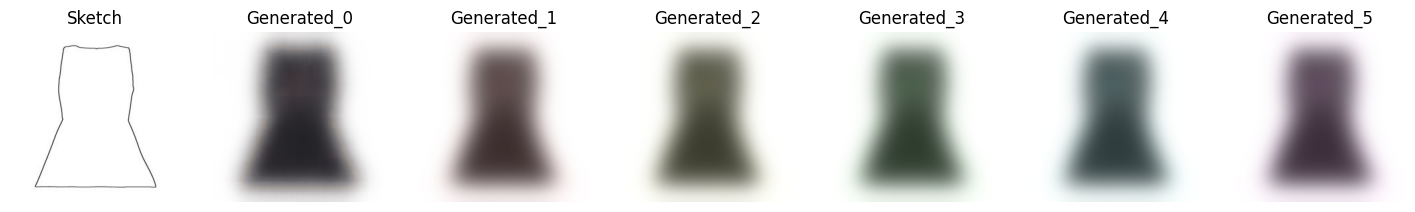

All images for sketch 1 saved successfully.


In [16]:
#################### READ THIS BEFORE PROCEDDING WITH THIS SECTION ########################################

# THIS CODE GENERATES THE INTERMEDIATE IMAGE WHICH WE ARE REFERRING TO AS 'CLUE IMAGE' USING THE CLUE_GENERATOR MODEL.
# ADD YOUR GOGLE DRIVE LINK FOLDER THAT CONTAINS THE SKETCH IMAGE YOU WANT TO PASS TO THE MODEL.
# ALSO ADD PATH TO SAVE THE GENERATED CLUE IMAGE IN THE DRIVE FOLDER.
# THE MODEL WORKS AT 256x256 RESOLUTION, MAY GIVE ERROR IF ANY OTHER RESOLUTION USED.
# THE WORKING LOGIC IS: THIS MODEL GENERATES ONE  CLUE IMAGE WHICH IS MOSTLY GREYISH, BUT USING PYTHON SCRIPT WE ARE GENERATING
# 5 VARIENTS OF THE SAME IMAGE USING HUE TRASNFORMATION, THIS ALLOWS OUR MAIN MODEL TO GENERATE DIFFERENT COLOR OUTPUT.
# ALONG WITH THE HUE TRANSFORMATION, WE ARE ALSO ADDING: GAUSSIAN BLUR, IMAGE ZOOM AND SATURATION ADJUSTMENTS FOR TECHNICAL REASON.
# IN THIS CODE THERE IS OPTION TO MANAULLY SELECT SKETCH IMAGE AND PASS IT TO THE MODEL OR YOUR CAN SET IT TO FALSE SO MODEL SELECTS ONE IMAGE ON
# RANDOMLY FROM PROVIDED DRIVE LINK(can be useful in some cases)
# ALL THE GENERATED CLUE IMAGE WILL BE SAVED IN THE PROVIDED SAVE_PATH WITH NAMES: sample_0.jpg (the raw output from the model), sample_1.jpg,
# sample_2.jpg ... sample_5.jpg (the transformed output by the python script)

############################################################################################################



import os
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# ADD YOUR PATHS APPROPRIATELY
SAVE_PATH = '/content/drive/MyDrive/EVERYTHING_GAN/REFERENCE_FOLDER_FOR_IMAGES/CLUE_IMAGES/'  # saving the generated image
SKETCH_FOLDER = '/content/drive/MyDrive/EVERYTHING_GAN/REFERENCE_FOLDER_FOR_IMAGES/SKETCH_IMAGES/' #input sketch image

# KEEP THIS PATH AS IT IS
MODEL_PATH = 'clue_model/model_clue.h5'

os.makedirs(SAVE_PATH, exist_ok=True)

# Load the pre-trained model
model = load_model(MODEL_PATH)

def plot_images(src_img, gen_imgs, titles):
    """
    Display source and generated images in a single row.
    :param src_img: Source image.
    :param gen_imgs: List of generated images.
    :param titles: List of titles for the images.
    """
    images = [src_img] + gen_imgs
    images = [(img + 1) / 2.0 for img in images]  # Scale to [0, 1]
    num_images = len(images)
    plt.figure(figsize=(18, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

def apply_vibrant_hue_and_blur(image, num_variants=5, zoom_level=1.05):
    """
    Generate hue-shifted and blurred variants of an image.
    :param image: Input image in RGB format.
    :param num_variants: Number of variants to generate.
    :param zoom_level: Zoom factor for the image.
    :return: List of processed images.
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    generated_images = []
    vibrant_hues = [0, 30, 60, 90, 150]  # Predefined hues

    for i in range(num_variants):
        # Adjust hue, saturation, and brightness
        modified_hsv = hsv_image.copy()
        modified_hsv[..., 0] = vibrant_hues[i % len(vibrant_hues)]
        modified_hsv[..., 1] = np.clip(modified_hsv[..., 1] * 1.8, 0, 255)
        modified_hsv[..., 2] = np.clip(modified_hsv[..., 2] * 1.5, 0, 255)

        # Convert back to RGB
        vibrant_image = cv2.cvtColor(modified_hsv, cv2.COLOR_HSV2RGB)

        # Zoom the image
        h, w, _ = vibrant_image.shape
        center_x, center_y = w // 2, h // 2
        new_w, new_h = int(w / zoom_level), int(h / zoom_level)
        cropped_img = vibrant_image[
            center_y - new_h // 2:center_y + new_h // 2,
            center_x - new_w // 2:center_x + new_w // 2
        ]
        zoomed_image = cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_LINEAR)

        # Apply Gaussian blur
        blurred_image = cv2.GaussianBlur(zoomed_image, (81, 81), 0)

        # Normalize to [-1, 1] range
        blurred_image = (blurred_image / 127.5) - 1
        generated_images.append(blurred_image)

    return generated_images

def select_sketch(manual_selection=True, sketch_name=None):
    """
    Select a sketch image either manually or randomly from the sketch folder.
    :param manual_selection: Boolean to enable manual selection.
    :param sketch_name: Name of the sketch file to select manually.
    :return: Path to the selected sketch and its number.
    """
    if manual_selection:
        if not sketch_name:
            raise ValueError("Sketch name must be provided for manual selection.")
        if sketch_name not in os.listdir(SKETCH_FOLDER):
            raise FileNotFoundError(f"Specified sketch file '{sketch_name}' not found in the folder.")
        selected_sketch = sketch_name
    else:
        sketch_files = [f for f in os.listdir(SKETCH_FOLDER) if f.endswith('.jpg')]
        if not sketch_files:
            raise FileNotFoundError("No sketches found in the folder.")
        selected_sketch = np.random.choice(sketch_files)

    sketch_number = os.path.splitext(selected_sketch)[0]
    sketch_path = os.path.join(SKETCH_FOLDER, selected_sketch)
    return sketch_path, sketch_number

def process_and_save_images(sketch_path, sketch_number):
    """
    Process the selected sketch, generate images, and save them.
    :param sketch_path: Path to the sketch image.
    :param sketch_number: Sketch identifier.
    """
    # Preprocess the sketch
    source_image = cv2.imread(sketch_path, cv2.IMREAD_COLOR)
    source_image = cv2.resize(source_image, (256, 256))
    source_image = (source_image / 127.5) - 1

    # Generate image
    source_image_input = np.expand_dims(source_image, axis=0)
    generated_image = model.predict(source_image_input)
    generated_image_rgb = ((generated_image[0] + 1) * 127.5).astype(np.uint8)

    # Apply hue adjustment and blur
    generated_variants = apply_vibrant_hue_and_blur(generated_image_rgb, num_variants=5)

    # Display results
    plot_titles = ['Sketch', 'Generated_0'] + [f'Generated_{i + 1}' for i in range(5)]
    plot_images(source_image, [generated_image[0]] + generated_variants, plot_titles)

    # Save images
    gen_image_bgr = cv2.cvtColor(generated_image_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(SAVE_PATH, f"{sketch_number}_0.jpg"), gen_image_bgr)

    for i, variant in enumerate(generated_variants):
        variant_rgb = ((variant + 1) * 127.5).astype(np.uint8)
        variant_bgr = cv2.cvtColor(variant_rgb, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(SAVE_PATH, f"{sketch_number}_{i + 1}.jpg"), variant_bgr)

    print(f"All images for sketch {sketch_number} saved successfully.")




###############################################################################################
manual_selection = True  # SET TO FALSE IF YOU WANT MODEL TO SELECT AN IMAGE AT RANDOM.
selected_sketch_path, selected_sketch_number = select_sketch(
    manual_selection=manual_selection,
    sketch_name='1.jpg'  # REPLACE WITH DESIRED FILE NAME IF MANUAL SELECTION IS ENABLED.
)
process_and_save_images(selected_sketch_path, selected_sketch_number)

###############################################################################################

1/1 [==============================] - 1s 725ms/step


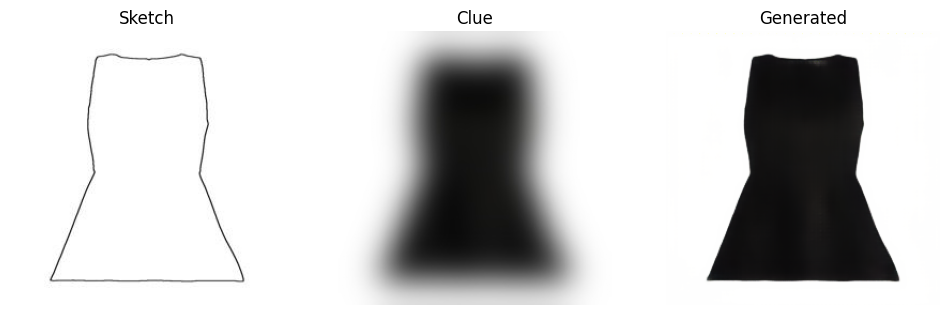

1/1 [==============================] - 0s 376ms/step


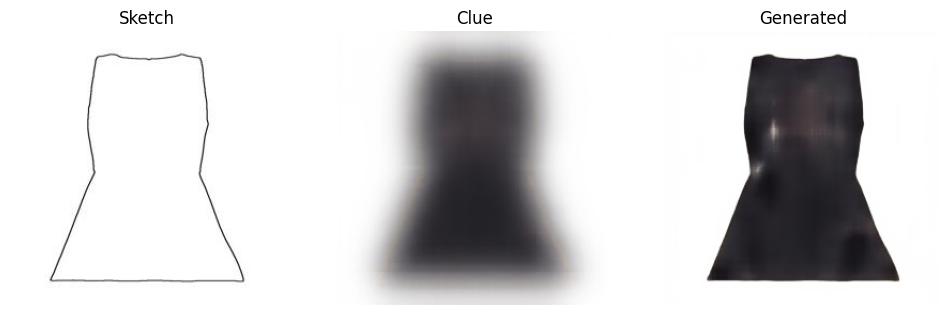

1/1 [==============================] - 0s 349ms/step


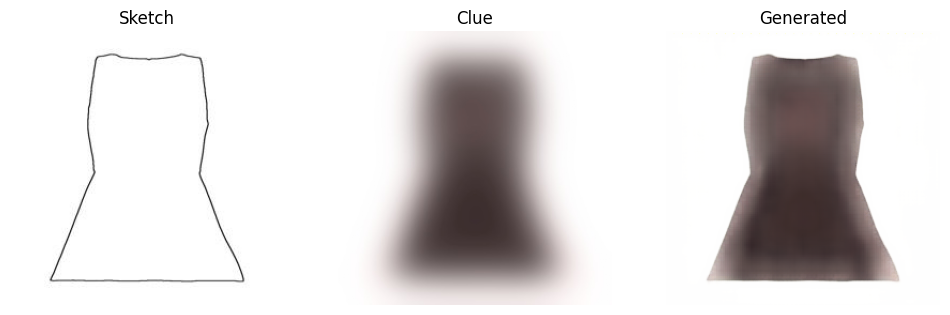

1/1 [==============================] - 0s 359ms/step


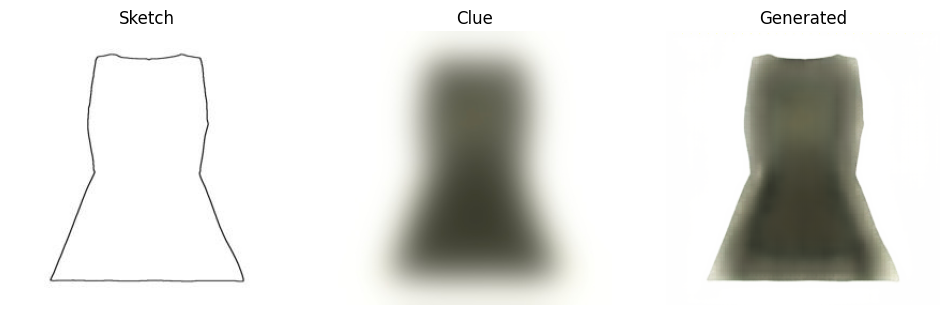

1/1 [==============================] - 0s 342ms/step


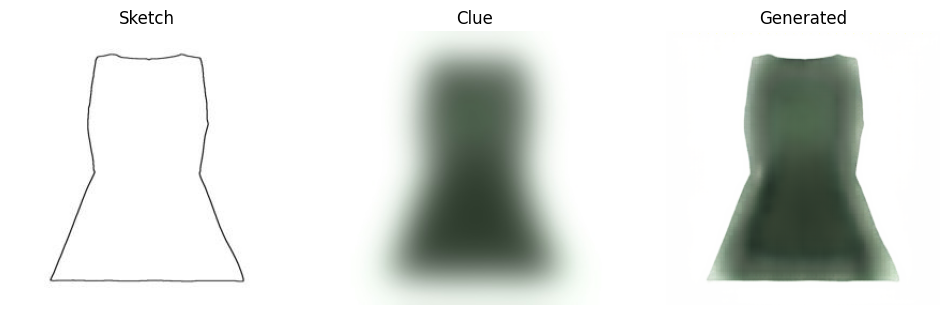

1/1 [==============================] - 0s 376ms/step


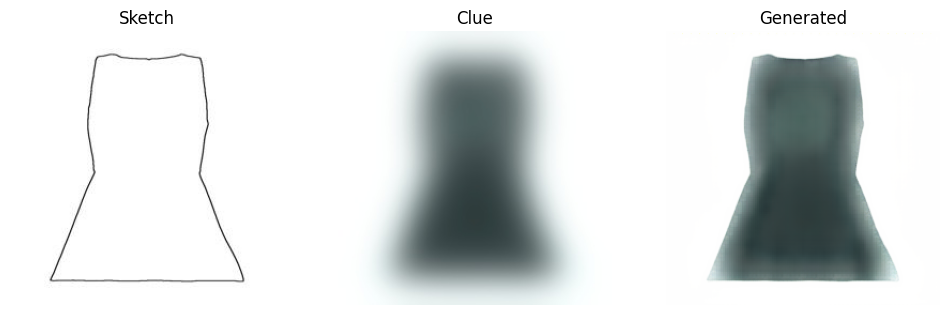

1/1 [==============================] - 0s 357ms/step


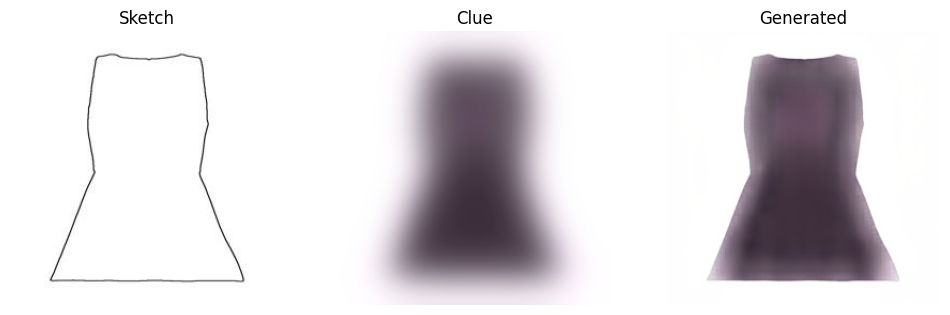

In [17]:
#################### READ THIS BEFORE PROCEDDING WITH THIS SECTION ##############################################################################################

# THIS CODE GENERATES THE FINAL IMAGE: TAKING THE SKETCH IMAGE AND CLUE IMAGE AS INPUT, THIS USES THE OUTPUT_GENERATOR MODEL.
# THIS ALSO ONLY TAKES IMAGE OF 256X256 RESOLUTION
# THIS CODE USES THE PATH PROVIDED EARLIER IN THE SECTION ABOVE TO REFERENCE TO THE INPUT SKETCH AND GENERATED CLUE IMAGE.
# SAME MANUAL SECTION LOGIC SAME AS BEFORE. IT IT DOESN'T FILE THE CORREPONDING CLUE IMAGE IT WILL PASS NULL ARRAY AS CLUE INPUT.
# IMPORTANT TECHINICAL DETAIL: THE SKETCH IS PROCESSED AS SINGLE CHANNEL, CLUE IMAGE AS 3 CHANNEL (the code does it, not intervention required).

###################################################################################################################################################################



import os
import random
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from keras.models import load_model
import matplotlib.pyplot as plt

#########################################################################################

# Option to manually select the sketch
manual_selection = True  # Set to True for manual selection, False for random
manual_sketch_name = "1.jpg"  # Specify sketch name if manual_selection is True

#########################################################################################

# Define folder paths
folder_path_in_drive = '/content/drive/MyDrive/EVERYTHING_GAN/REFERENCE_FOLDER_FOR_IMAGES/'
sketch_folder = os.path.join(folder_path_in_drive, 'SKETCH_IMAGES')
clue_folder = os.path.join(folder_path_in_drive, 'CLUE_IMAGES')

# Fixing the image input resolution
image_horizontal = 256
image_vertical = 256



# Function to preprocess images
def preprocess_image(image_path, size=(image_horizontal, image_vertical), color_mode='grayscale'):
    image = load_img(image_path, target_size=size, color_mode=color_mode)
    image = img_to_array(image)
    return (image - 127.5) / 127.5

# Load the pre-trained model
model = load_model('main_model/model_main.h5')

# Function to ensure all images have 3 channels
def to_rgb(image):
    if image.shape[-1] == 1:  # Grayscale image
        return np.repeat(image, 3, axis=-1)
    return image  # Already RGB

# Plot and save images
def plot_and_save_images(sketch_img, clue_img, gen_img, sketch_id, clue_index, save_generated_image=False, save_folder='/content/'):
    # Convert all images to RGB
    sketch_img, clue_img, gen_img = map(to_rgb, [sketch_img, clue_img, gen_img])

    # Scale from [-1,1] to [0,1]
    sketch_img, clue_img, gen_img = (sketch_img + 1) / 2.0, (clue_img + 1) / 2.0, (gen_img + 1) / 2.0

    # Titles and filenames
    titles = ['Sketch', 'Clue', 'Generated']
    filenames = [
        f"{sketch_id}_sketch.jpg",
        f"{sketch_id}_{clue_index}_clue.jpg",
        f"{sketch_id}_{clue_index}_generated.jpg",
    ]

    # Plot images
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    images = [sketch_img, clue_img, gen_img]
    for i in range(3):
        axs[i].imshow(images[i])
        axs[i].axis('off')
        axs[i].set_title(titles[i])

    plt.show()

    # Save generated image
    if(save_generated_image==True):
      gen_save_path = os.path.join(save_folder, filenames[2])
      plt.imsave(gen_save_path, gen_img)
      print(f"Generated image saved to {gen_save_path}")

# Main inference logic
try:
    # Select a sketch
    if manual_selection:
        sketch_path = os.path.join(sketch_folder, manual_sketch_name)
        if not os.path.exists(sketch_path):
            raise FileNotFoundError(f"Sketch {manual_sketch_name} not found in {sketch_folder}")
        sketch_id = os.path.splitext(manual_sketch_name)[0]
    else:
        sketch_files = os.listdir(sketch_folder)
        if not sketch_files:
            raise FileNotFoundError(f"No sketches found in {sketch_folder}")
        sketch_file = random.choice(sketch_files)
        sketch_path = os.path.join(sketch_folder, sketch_file)
        sketch_id = os.path.splitext(sketch_file)[0]

    # Preprocess the sketch image
    sketch_image = preprocess_image(sketch_path)

    # Check for single clue file (e.g., "14.jpg")
    clue_paths = []
    single_clue_path = os.path.join(clue_folder, f"{sketch_id}.jpg")
    if os.path.exists(single_clue_path):
        clue_paths.append(single_clue_path)

    # Search for other clues (e.g., "14_1.jpg", "14_2.jpg")
    additional_clues = [
        os.path.join(clue_folder, f) for f in os.listdir(clue_folder)
        if f.startswith(sketch_id + "_") and f.endswith(".jpg")
    ]
    clue_paths.extend(additional_clues)

    # If no clues are found, proceed without clue
    if not clue_paths:
        print(f"No clues found for sketch {sketch_id}. Generating default outputs...")
        clue_paths = [None]  # Placeholder to indicate no clue

    # Process each clue and generate images
    for idx, clue_path in enumerate(clue_paths, start=1):
        clue_image = None
        if clue_path:
            clue_image = preprocess_image(clue_path, color_mode='rgb')
            gen_image = model.predict([sketch_image[None, ...], clue_image[None, ...]])[0]
        else:
            # Generate without clue if no clue is provided
            gen_image = model.predict([sketch_image[None, ...]])[0]

        # Plot and save the results
        plot_and_save_images(
            sketch_image,
            clue_image if clue_image is not None else np.zeros_like(sketch_image),  # Empty image for display
            gen_image,
            sketch_id,
            idx,
            save_generated_image=False # SET THIS TO TRUE IF YOU WANT TO SAVE THE GENERATED OUTPUT IN COLLAB LOCAL STORAGE
        )

except Exception as e:
    print(f"Error: {e}")
